### Librerias

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,  roc_curve, auc, accuracy_score



### Lectura set de datos

In [6]:
df = pd.read_csv(path)

### Analisis exploratorio

In [7]:
print(f'volumentria: {df.shape}')
print('****')
print('tipo datos y completitud:')
print(df.info())
print('****')
print('muestra rapida:')
print(df.head(5))
print('****')
print('inspeccion variables numericas:')
print(df[['x1', 'x2', 'x5', 'x6', 'x7', 'x8']].describe())

# 2000 registros con 9 variables

volumentria: (2000, 9)
****
tipo datos y completitud:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   object 
 3   x4      2000 non-null   object 
 4   x5      2000 non-null   int64  
 5   x6      2000 non-null   int64  
 6   x7      2000 non-null   int64  
 7   x8      2000 non-null   float64
 8   target  2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB
None
****
muestra rapida:
         x1        x2   x3     x4  x5  x6  x7   x8  target
0   50.1341 -326.0000  SAT  MZBER   0   0   6 -6.5       0
1   50.1341 -326.0000  SAT  MZBER   0   0   6 -4.5       0
2  124.3276 -275.1935  LCV  MZBER   0   0   3 -2.5       0
3   50.1341 -326.0000  SAT  MZBER   0   0   3 -4.5       0
4   85.3905 -298.8632  XJB  MZBER   0   0   5 -4

A nivel general se tiene un set de datos relativamente pequeño, sin presencia de datos faltantes. Se ve presencia de datos categoricos (X3 y X4) que deben ser traducidos para su representacion númerica (binario), ademas de x5 y x6 que si bien vienen ya representados nuemrciamente, dada la inspeccion de sus descriptores tambien estarían representando una variable categorica (0 y 1).

Se procede a revisar el comportamiento de la variable target:

col_0   Frecuencia
target            
0             1978
1               22


Text(0.5, 1.0, 'Frecuencia de variable target')

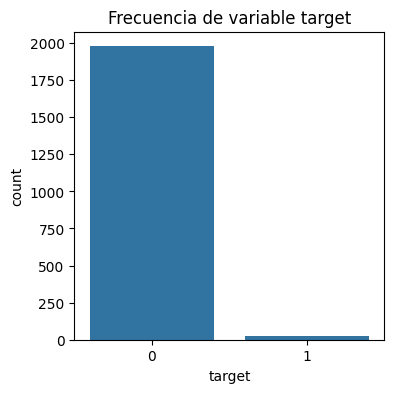

In [8]:
var_taget = pd.crosstab(index = df['target'], columns = 'Frecuencia', margins = False)

print(var_taget)

plt.figure(figsize=(4,4))
sns.countplot(x=df['target']);
plt.title('Frecuencia de variable target')



Rapidamente se puede visualizar la muy baja presencia de clase 1 para variable target, anticipando desde ya un modelaje que tendrá que hacerse cargo del desbalance de dichas clases.

A continuación, generando la transofrmacion a su representacion numerica las variables categoricas, se procede a posterior a inspeccionar el comprtamiento de las variables independientes:

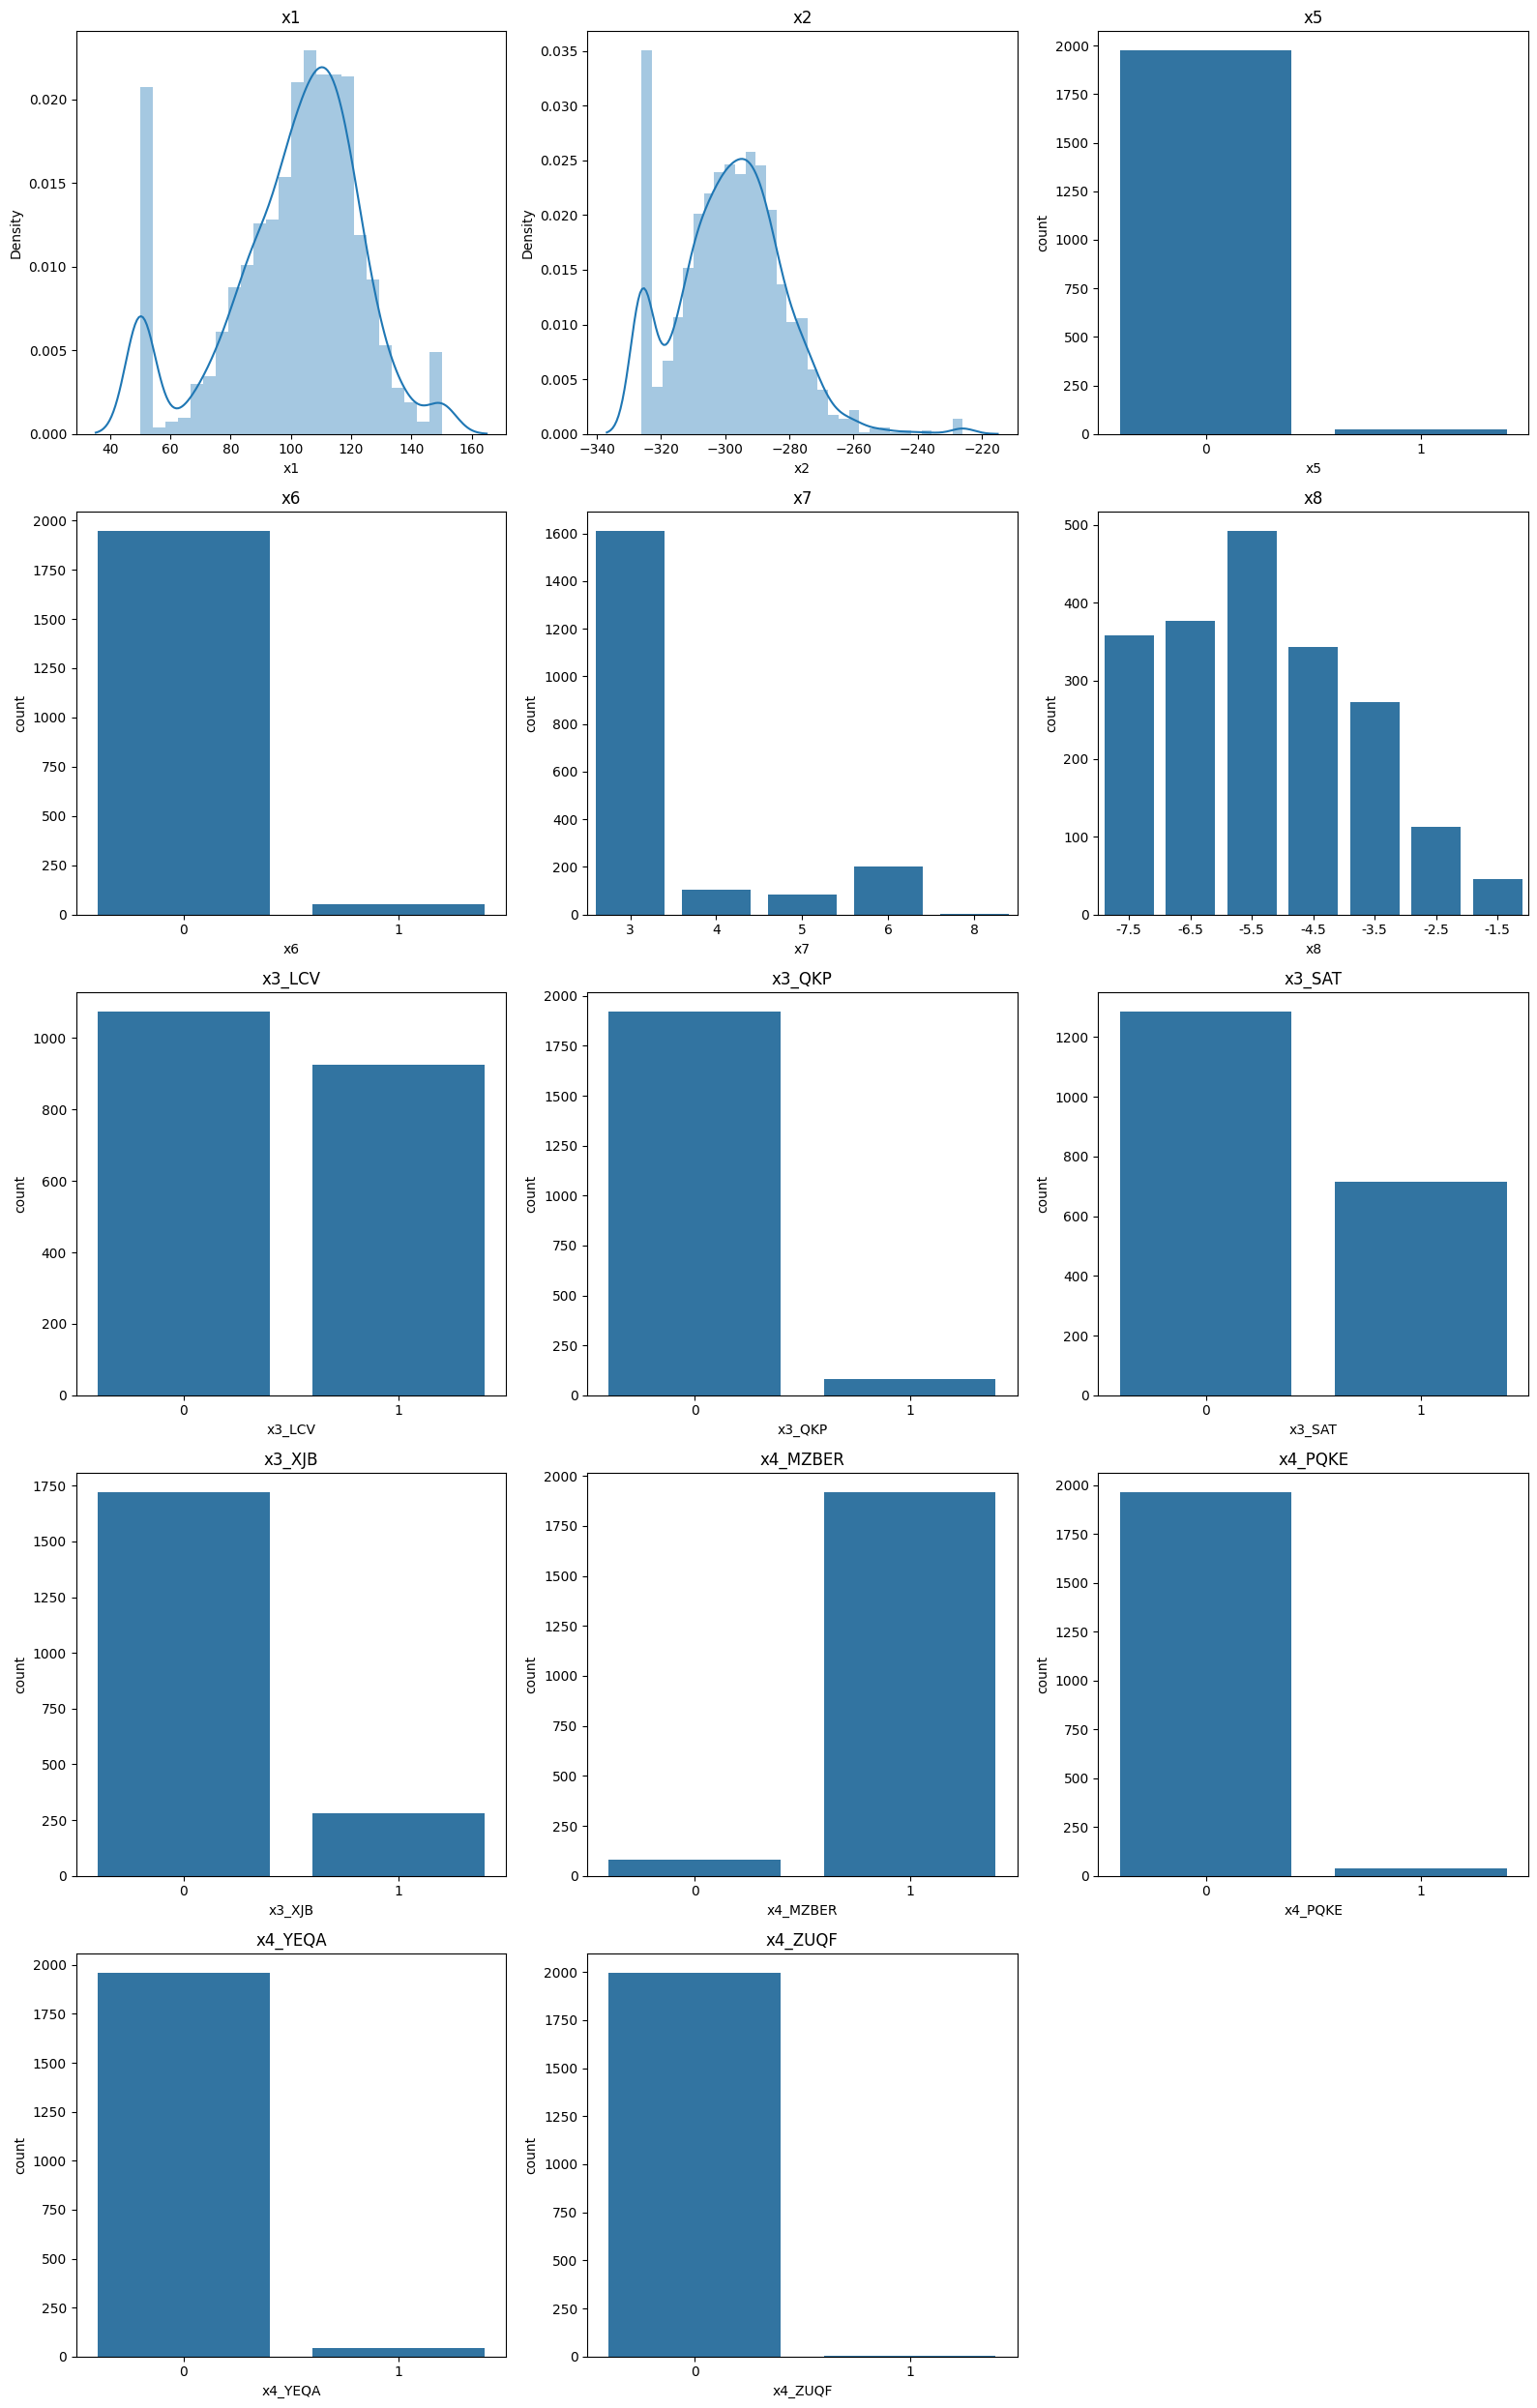

In [9]:
#Transofrmacion de X3 y X4 via get_dummies para representacion numerica de las categorias. Se mantiene el drop_first en False para inspeccion compltea:
df_encoded = pd.get_dummies(df, columns=['x3', 'x4'], drop_first=False, dtype='int')


warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"]=(16,25)
for n, i in enumerate(df_encoded.drop('target', axis = 1)):
    plt.subplot(5,3,n+1)
    if len(df_encoded[i].value_counts())>10:
        # print(i)
        sns.distplot(df_encoded[i]);
        plt.title(i)
    else:
        # print(f'count{i}')
        sns.countplot(x=df_encoded[i]);
        plt.title(i)
        plt.tight_layout()


A nivel visual se pueden ir generando las siguientes hipotesis:
1. Si bien x1 y x2 estan en distintas escalas y siendoe stas variables continuas, en primera instancia por su comportamiento en cuanto a la distribucion de densidad, se tendería a pensar que se comportan de manera similar (quiza están correlacionadas), lo cual la presencia de ambas no aportaría al modelado.
2. Mismo caso con x5 y x6, que siendo categoricas presentan un comportamiento similar, pero se desconoce si describen la misma categoria. Habrioa que inspeccionar de manera mas profunda.
3. x7 concentra su frecuencia en valor 3, por lo que podriamos adelantarnos a que encontraremos valore soutliers relacionado a dicha variable.
4. Para las variable sderibadas de la categoria x3, se debe revisar correlaciones para no sobrecargar modelo ya que algunas presentan conductas similares.
5. Mismo caso anterior se aplica para las variables derivadas de la categoria correspondiente a x4.

Dado lo anterior se inspeccion correlacion entre las variables:

Matriz correlacion:


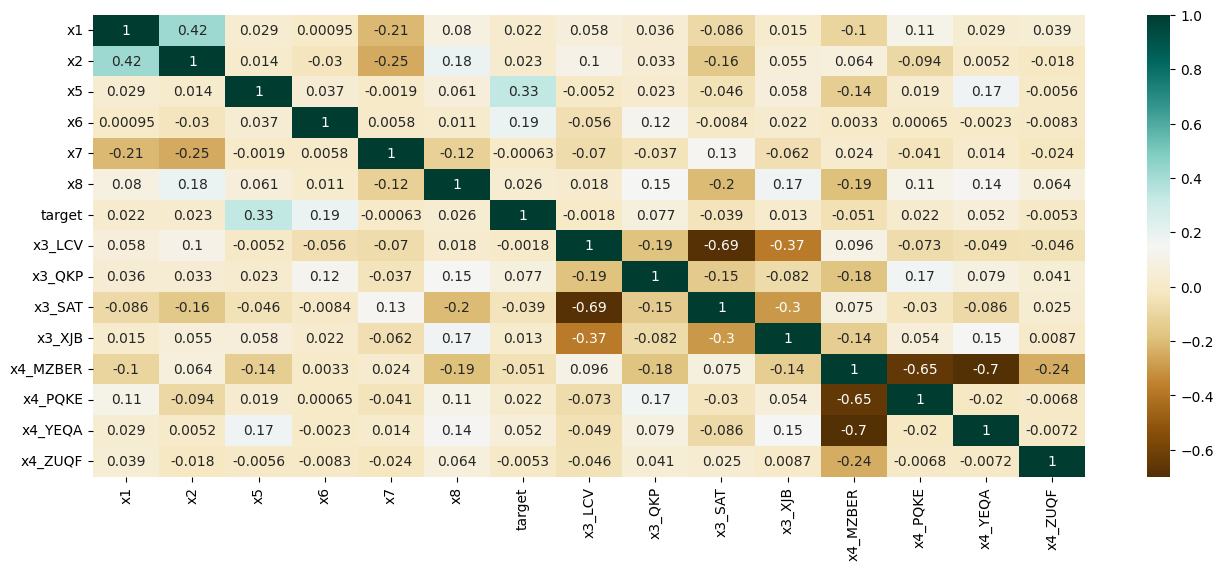

In [10]:
## se utiliza spearman por ser menos propensa a outliers que pueden aparecer mas adelante en el analisis... 
corr_categorical = df_encoded.corr(method='spearman')
print("Matriz correlacion:")

# np.triu(np.ones_like(corr_bancoS))
# mask = np.triu(np.ones_like(corr_bancoS, dtype=np.bool))

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_categorical, cmap = "BrBG", annot=True)

Mediante inspeccion de correlaciones se deriva lo siguiente:
1. Fuerte correlación entre x1 y x2, por lo que mantener las dos en el modelo no aportaria explicabilidad y ensuciaria coefientes (entre otros alcances). Se opta por mantener x1 dada su mayor correlacion con target, aunque es minima.
2. x4_MZBER posee correlacion fuerte (negativa) con x4_YEQA y x4_PQKE. Esto es esperable dado que en la generacion de dummies se utilizo drop_first = False. Las dos variables que mantienen correlacion furte con x4_MZBER no serían incluidas en modelo.
3. x3_SAT posee correlacion fuerte (negativa) con x3_XJB y x3_LCV. Esto es esperable dado que en la generacion de dummies se utilizo drop_first = False. Las dos variables que mantienen correlacion furte con x3_SAT no serían incluidas en modelo.
4. Se generó hipotesis anteriormente sobre comportamiento similar entre x5 y x6, pero en la inspección de correlación no se  evidencian pruebas para descartar una u otra en modelo.

Con estos alcances, se procede a hacer drop de las variables ya indicadas del dataset.

In [251]:
df_encoded_clean_v = df_encoded.drop(['x2', 'x3_LCV', 'x3_XJB', 'x4_YEQA', 'x4_PQKE'], axis = 1)
df_encoded_clean_v

,x1,x5,x6,x7,x8,target,x3_QKP,x3_SAT,x4_MZBER,x4_ZUQF
0,50.1341,0,0,6,-6.5,0,0,1,1,0
1,50.1341,0,0,6,-4.5,0,0,1,1,0
2,124.3276,0,0,3,-2.5,0,0,0,1,0
3,50.1341,0,0,3,-4.5,0,0,1,1,0
4,85.3905,0,0,5,-4.5,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1995,119.2548,0,0,3,-2.5,0,1,0,1,0
1996,106.2410,0,0,3,-2.5,0,0,0,0,0
1997,127.0572,0,0,3,-5.5,0,0,1,1,0
1998,114.4653,0,0,3,-5.5,0,0,0,1,0


Se procede a revisar el comprtamiento de las variables numericas(continuas y discretas), a saber x1, x7 y x8, en relacion a la variable objetivo, de manera visual:

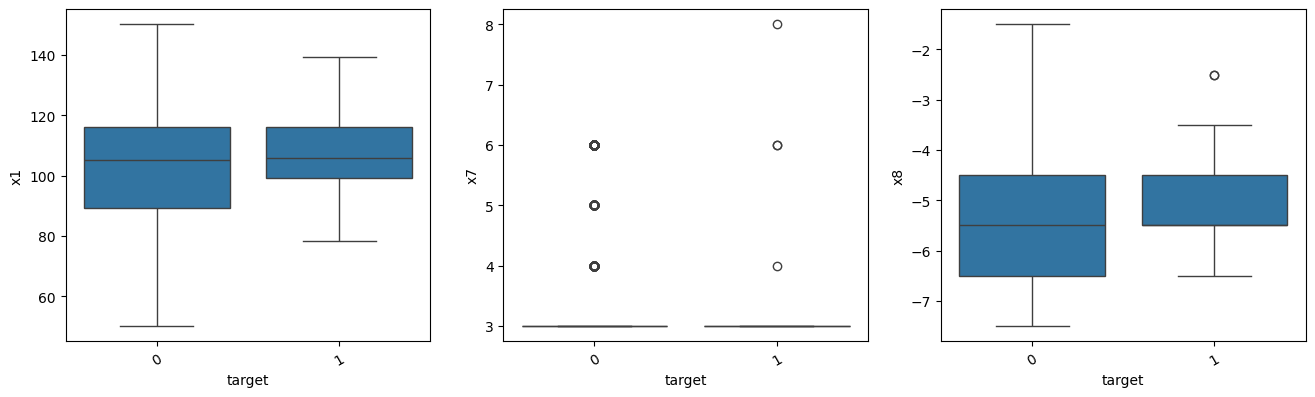

In [252]:

warnings.filterwarnings("ignore")
for n, i in enumerate(df_encoded_clean_v[['x1', 'x7', 'x8']]):
    plt.subplot(5,3,n+1)
    ax = sns.boxplot(x='target',y=df_encoded_clean_v[i],data=df_encoded_clean_v,showfliers=True);
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

De relavenacia en este apartado, podemos ver presencia de algunos outliers en x7 y x8. Por desbalanceo de clase target ya indicado, se trabajan los outliers solo asociados a x7 con respuesta en target igual a 0, con el fin de mejorar la calidad de los registros a la vez de no afectar aún más el desbalance:

In [253]:

data_target_1 = df_encoded_clean_v[df_encoded_clean_v['target'] == 1]
data_target_0 = df_encoded_clean_v[df_encoded_clean_v['target'] == 0]


cols_with_outliers = ['x7', 'x8']
Q1 = data_target_0[cols_with_outliers].quantile(0.25)
Q3 = data_target_0[cols_with_outliers].quantile(0.75)
IQR = Q3 - Q1


data_target_0_clean = data_target_0[~((data_target_0[cols_with_outliers] < (Q1 - 1.5 * IQR)) | (data_target_0[cols_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]


data_clean = pd.concat([data_target_0_clean, data_target_1], axis=0)


Finalmente se obtiene set de datos final a modelar, a saber compuesto por las variables independientes x1, x3_SAT, x3_QKP, x4_MZBER, x5, x6, x7 y x8.

In [254]:
data_clean

,x1,x5,x6,x7,x8,target,x3_QKP,x3_SAT,x4_MZBER,x4_ZUQF
2,124.3276,0,0,3,-2.5,0,0,0,1,0
3,50.1341,0,0,3,-4.5,0,0,1,1,0
5,102.1572,0,0,3,-3.5,0,0,0,1,0
6,117.5363,0,0,3,-3.5,0,0,0,1,0
7,83.9107,0,0,3,-5.5,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1732,114.0230,0,1,3,-5.5,1,0,0,1,0
1907,110.1341,1,1,6,-5.5,1,0,1,1,0
1945,108.4797,1,1,3,-4.5,1,1,0,1,0
1954,139.3903,0,0,3,-3.5,1,0,0,1,0


Este precio a pasar a modelamiento se trabajan las variables x1, x7 y x8 (numericas continuas y ) para el escalamiento de los datos previo a entrar a modelo:

In [256]:

scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_scale = ['x1','x7', 'x8']
data_clean[columns_to_scale] = scaler.fit_transform(data_clean[columns_to_scale])

data_clean


,x1,x5,x6,x7,x8,target,x3_QKP,x3_SAT,x4_MZBER,x4_ZUQF
2,0.741935,0,0,0.0,0.833333,0,0,0,1,0
3,0.000000,0,0,0.0,0.500000,0,0,1,1,0
5,0.520231,0,0,0.0,0.666667,0,0,0,1,0
6,0.674022,0,0,0.0,0.666667,0,0,0,1,0
7,0.337766,0,0,0.0,0.333333,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1732,0.638889,0,1,0.0,0.333333,1,0,0,1,0
1907,0.600000,1,1,0.6,0.333333,1,0,1,1,0
1945,0.583456,1,1,0.0,0.500000,1,1,0,1,0
1954,0.892562,0,0,0.0,0.666667,1,0,0,1,0


#### Modelamiento [RegresionLogistica]

En primera isntancia se genera la division de datos en train y test, con parametros:
1. test_size = 0.3. Se aumento del 0.2 típico utilizado dado tema de desbalance.
2. stratify = yes. Esto con el fin de mantener la propocion de la presencia de las clases en target en train y test.

In [257]:


X = data_clean.drop('target', axis=1)  
y = data_clean['target']                

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Se trabaja el desbalance mediante over sampling en train, y se evalua frecuencias de target en dichos datos:

In [258]:



smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_balanced.value_counts()


target
0    1114
1    1114
Name: count, dtype: int64

In [259]:
y_test.value_counts()

target
0    478
1      7
Name: count, dtype: int64

Se crea clase de LogisticRegression, se hace fit con data de entrenamiento:

In [283]:


model = LogisticRegression()
model.fit(X_train_balanced, y_train_balanced)

# list(zip(X.columns, model.coef_.flatten(),))

LogisticRegression()

A continuación se generan las pruebas en test de predicciones del modelo y se calculan metricas AUC:

In [287]:

# Predecir en el conjunto de prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# AUC
y_train_prob = model.predict_proba(X_train_balanced)[:, 1]



y_test_prob = model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train_balanced, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)


print(f"AUC Train: {auc_train}")
print(f"AUC Test: {auc_test}")
# print(f"F1 Score: {f1:.4f}")


cm = confusion_matrix(y_test, y_test_pred)
print('matriz de confusion:')
print(cm)

# AUC en conjunto de prueba (con SMOTE): 0.9061566049013748
# AUC en conjunto de train (con SMOTE): 0.801035619776373


AUC Train: 0.801035619776373
AUC Test: 0.9061566049013748
matriz de confusion:
[[312 166]
 [  0   7]]


Se visualiza un menor rendimiento del modelo en los datos de entrenamiento, aunque en este conjunto alcanza una capacidad de clasificación aceptable, logrando distinguir entre las clases de target con un buen nivel. Para el conjunto de test alcanza un mejor rendimiento, capacidad de clasificacion y distincion entre las clases target. No obstante, se ha de reconocer que comunmente se espera una menor capacidad de distinción en test que en train, pero no necesariamente es una condicion estricta, mas se puede atribuir este escenario a la variabilidad de los datos de test y train por el modo de su construcción. Así, se vuelve razonable la implementación de un cross validation entorno al muestreo de test y train, lo cual no ha sido implementado en esta entrega.

En cuanto a la matriz de confusion generada a partir de un threshold estandar de 0.5 genera clasificaciones correctas entorno a los FN (no clasificó ningun negativo como positivo), TP (todos los positivos los clasificó como positivos) alcanzando un accuracy de 0.73. Además presenta un recall de 1 corroborando su capacidad de deteccion de casos positivos. No obstante a nivel de presicion, indicando el nivel de predicciones positivas correctas es deficiente, alcanzando solo un 5%. En otras palabras, el modelo es bueno clasificando positivos a costa de una alta presencia de falsos positivos.
 
A continuación se muestran las curvas ROC, donde se evidencia que la capacidad de clasificacion del modelo, con sus particularidades ya descritas es mejor que una clasificacion aleatoria (recta punteada), pór lo que puede ser de utilidad segun el contexto del problema al que se requiera aplicar.


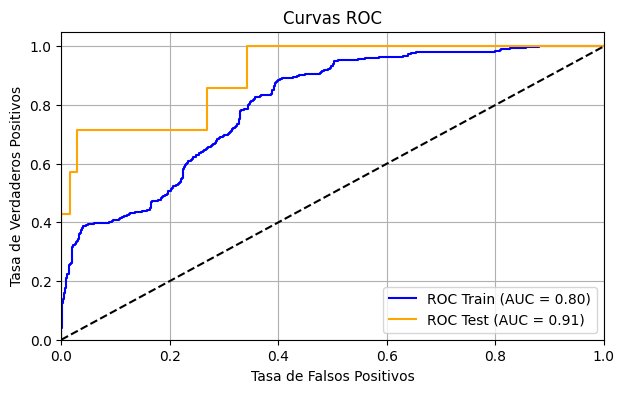

In [292]:

fpr_train, tpr_train, _ = roc_curve(y_train_balanced, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(7, 4))
plt.plot(fpr_train, tpr_train, label=f'ROC Train (AUC = {auc( fpr_train, tpr_train):.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'ROC Test (AUC = {auc_test:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Finalmente se busca el threshold óptimo y se calcula F1-Score: 

In [293]:

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calcular la distancia al punto (0,1)
distances = np.sqrt((fpr**2) + ((1 - tpr)**2))
best_threshold_index = np.argmin(distances)
best_threshold = thresholds[best_threshold_index]

print(f"Mejor threshold: {best_threshold}")

y_pred_best_threshold = (y_test_prob >= best_threshold).astype(int)

cm_best = confusion_matrix(y_test, y_pred_best_threshold)
print("Matriz de Confusión (con mejor threshold):")
print(cm_best)

f1_best = f1_score(y_test, y_pred_best_threshold)
accuracy_best = accuracy_score(y_test, y_pred_best_threshold)

print(f"F1 Score (con mejor threshold): {f1_best}")


Mejor threshold: 0.7347489875137806
Matriz de Confusión (con mejor threshold):
[[464  14]
 [  2   5]]
F1 Score (con mejor threshold): 0.38461538461538464


Se determina como mejor threshold 0.73 (menor distancia a coordenada 0,1 en curva ROC), modificando la matriz de confucion como se muestra en la parte superior. Disminuyendo el recall (ahora si hay pressencia de clasficiacion erronea de positivos), pero mejorando en mas de 20 puntos porcentuales la capacidad de clasificar correctamente las positivas (a costa de una disminucion de FP). Esto evidencia los problemas del modelo para equilibrar entre recall y precision, y que se muestran en un F1-Score de 0.38. Cabe destacar que este es un F1Score  relativamente bajo pero con un alto recall, lo cual puede, segun el contexto del problema, asegurar la determinacion de los positivos cuando esto es mas importante.